## Import Libraries

In [1]:
import os
import glob
import re
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset
from torch.optim import AdamW

# Fix for torch.utils._pytree compatibility issue
import sys
if not hasattr(torch.utils._pytree, 'register_pytree_node'):
    # Add compatibility shim for older PyTorch versions
    torch.utils._pytree.register_pytree_node = lambda *args, **kwargs: None

from transformers import (
    BertTokenizer, 
    BertForSequenceClassification, 
    get_linear_schedule_with_warmup
)
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Set random seeds for reproducibility
RANDOM_SEED = 42
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(RANDOM_SEED)

Using device: cuda


## Configuration

In [ ]:
# Data configuration
DATA_PATH = "Raw Data/all"
FEATURE_COLUMNS = ['FPOGX', 'FPOGY', 'LPS', 'RPS', 'LPMM', 'RPMM']

# BERT configuration
MODEL_NAME = 'bert-base-uncased'
MAX_LENGTH = 256
BATCH_SIZE = 4
LEARNING_RATE = 2e-5
NUM_EPOCHS = 3
WARMUP_STEPS = 50
MAX_GRAD_NORM = 1.0


## Data Loading and Preprocessing with User ID Extraction

In [ ]:
class EyeTrackingDataset(Dataset):
    def __init__(self, data_path, feature_columns, tokenizer, max_length=256, normalize=True):
        self.data_path = data_path
        self.feature_columns = feature_columns
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.normalize = normalize
        
        self.samples = []
        self.labels = []
        self.user_ids = []
        self.sequences = []
        
        self._load_data()
        self._preprocess_sequences()
        
    def _load_data(self):
        """Load CSV files and extract sequences with user IDs"""
        print("Loading data files...")
        
        label_map = {'literate': 1, 'illiterate': 0}
        
        for label_name, label_value in label_map.items():
            folder_path = os.path.join(self.data_path, label_name)
            if not os.path.exists(folder_path):
                print(f"Warning: {folder_path} does not exist")
                continue
                
            csv_files = glob.glob(os.path.join(folder_path, "*.csv"))
            print(f"Found {len(csv_files)} files in {label_name} folder")
            
            for csv_file in tqdm(csv_files, desc=f"Loading {label_name} files"):
                try:
                    df = pd.read_csv(csv_file)
                    
                    filename = os.path.basename(csv_file)
                    user_id = int(filename.split('_')[1])
                    
                    feature_data = df[self.feature_columns].copy()
                    feature_data = feature_data.fillna(feature_data.mean())
                    
                    if len(feature_data) > 0:
                        self.samples.append(csv_file)
                        self.labels.append(label_value)
                        self.user_ids.append(user_id)
                        self.sequences.append(feature_data.values)
                        
                except Exception as e:
                    print(f"Error loading {csv_file}: {e}")
                    continue
        
        print(f"Loaded {len(self.samples)} samples total")
        print(f"Unique users: {len(set(self.user_ids))}")
        print(f"Label distribution: {pd.Series(self.labels).value_counts().to_dict()}")
    
    def _preprocess_sequences(self):
        """Preprocess sequences for BERT input"""
        print("Preprocessing sequences...")
        
        if self.normalize:
            all_values = np.concatenate([seq.flatten() for seq in self.sequences])
            all_values = all_values[np.isfinite(all_values)]
            
            self.global_mean = np.mean(all_values)
            self.global_std = np.std(all_values)
            
            print(f"Global mean: {self.global_mean:.4f}, Global std: {self.global_std:.4f}")
        
        self.text_sequences = []
        
        for seq in tqdm(self.sequences, desc="Converting to text"):
            if self.normalize and self.global_std > 0:
                seq_normalized = (seq - self.global_mean) / self.global_std
                seq_normalized = np.clip(seq_normalized, -5, 5)
            else:
                seq_normalized = seq
            
            text_tokens = []
            for time_step in seq_normalized:
                feature_str = " ".join([f"{val:.2f}" for val in time_step])
                text_tokens.append(f"[{feature_str}]")
            
            text_sequence = " ".join(text_tokens)
            self.text_sequences.append(text_sequence)
        
        if self.text_sequences:
            print(f"Sample text sequence (first 200 chars): {self.text_sequences[0][:200]}...")
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        text = self.text_sequences[idx]
        label = self.labels[idx]
        user_id = self.user_ids[idx]
        
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long),
            'user_id': user_id
        }


## Initialize Tokenizer and Load Data

In [4]:
# Initialize BERT tokenizer
print("Initializing BERT tokenizer...")
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)

# Create dataset
print("Creating dataset...")
dataset = EyeTrackingDataset(
    data_path=DATA_PATH,
    feature_columns=FEATURE_COLUMNS,
    tokenizer=tokenizer,
    max_length=MAX_LENGTH,
    normalize=True
)

print(f"\nDataset created with {len(dataset)} samples")

# Get unique users for LOUO
unique_users = dataset.get_unique_users()
print(f"\nLeave-One-User-Out will iterate through {len(unique_users)} users")

Initializing BERT tokenizer...
Creating dataset...
Loading data files...
Found 650 files in literate folder


Loading literate files: 100%|██████████| 650/650 [00:01<00:00, 604.06it/s]


Found 849 files in illiterate folder


Loading illiterate files: 100%|██████████| 849/849 [00:01<00:00, 599.84it/s]


Loaded 1499 samples total
Label distribution: {0: 849, 1: 650}
Number of unique users: 30
User IDs: [1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]
Preprocessing sequences...
Global mean: 1.6271, Global std: 1.3663


Converting to text: 100%|██████████| 1499/1499 [00:00<00:00, 10511.04it/s]

Sample text sequence (first 200 chars): [-0.87 -0.84 -0.46 -0.46 1.62 2.11] [-1.01 -1.04 -0.48 -0.48 1.79 1.98] [-0.97 -1.08 -0.48 -0.49 1.85 2.02] [-0.97 -0.92 -0.48 -0.48 1.73 2.13] [-1.02 -0.69 -0.43 -0.43 1.85 1.84] [-0.99 -0.71 -0.44 -...

Dataset created with 1499 samples

Leave-One-User-Out will iterate through 30 users


## Model Training Functions

In [5]:
def create_data_loader(dataset, batch_size, shuffle=True):
    """Create a DataLoader for the dataset"""
    return DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        num_workers=0  # Set to 0 for Windows compatibility
    )

def train_epoch(model, data_loader, optimizer, scheduler, device):
    """Train the model for one epoch"""
    model.train()
    total_loss = 0
    correct_predictions = 0
    total_predictions = 0
    
    for batch in tqdm(data_loader, desc="Training", leave=False):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        optimizer.zero_grad()
        
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )
        
        loss = outputs.loss
        logits = outputs.logits
        
        # Calculate accuracy
        predictions = torch.argmax(logits, dim=-1)
        correct_predictions += (predictions == labels).sum().item()
        total_predictions += labels.size(0)
        
        total_loss += loss.item()
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), MAX_GRAD_NORM)
        
        optimizer.step()
        scheduler.step()
    
    return total_loss / len(data_loader), correct_predictions / total_predictions

def evaluate_model(model, data_loader, device):
    """Evaluate the model"""
    model.eval()
    total_loss = 0
    all_predictions = []
    all_labels = []
    
    with torch.no_grad():
        for batch in tqdm(data_loader, desc="Evaluating", leave=False):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )
            
            loss = outputs.loss
            logits = outputs.logits
            
            total_loss += loss.item()
            
            predictions = torch.argmax(logits, dim=-1)
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(
        all_labels, all_predictions, average='binary', zero_division=0
    )
    
    return {
        'loss': total_loss / len(data_loader),
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'predictions': all_predictions,
        'labels': all_labels
    }

## Leave-One-User-Out Cross-Validation

This section performs leave-one-user-out cross-validation where:
1. Each unique user is held out as a test set
2. All other users are used for training
3. The model is trained and evaluated for each user
4. Results are aggregated across all users

This approach evaluates how well the model generalizes to completely unseen users.

In [6]:
# Store results
user_results = []
all_predictions = []
all_true_labels = []

# Get user IDs array for splitting
user_ids_array = np.array(dataset.user_ids)

for fold_idx, test_user in enumerate(unique_users):
    print(f"\n{'='*60}")
    print(f"User {fold_idx + 1}/{len(unique_users)} - Testing on User {test_user}")
    print(f"{'='*60}")
    
    # Split dataset: train on all users except test_user
    train_idx = np.where(user_ids_array != test_user)[0]
    test_idx = np.where(user_ids_array == test_user)[0]
    
    print(f"Training samples: {len(train_idx)}")
    print(f"Test samples: {len(test_idx)}")
    
    # Create train and test datasets
    train_dataset = Subset(dataset, train_idx)
    test_dataset = Subset(dataset, test_idx)
    
    # Create data loaders
    train_loader = create_data_loader(train_dataset, BATCH_SIZE, shuffle=True)
    test_loader = create_data_loader(test_dataset, BATCH_SIZE, shuffle=False)
    
    # Initialize model
    model = BertForSequenceClassification.from_pretrained(
        MODEL_NAME,
        num_labels=2,
        output_attentions=False,
        output_hidden_states=False
    )
    model.to(device)
    
    # Initialize optimizer and scheduler
    optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, eps=1e-8)
    total_steps = len(train_loader) * NUM_EPOCHS
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=WARMUP_STEPS,
        num_training_steps=total_steps
    )
    
    # Training loop
    best_train_acc = 0
    
    for epoch in range(NUM_EPOCHS):
        # Train
        train_loss, train_accuracy = train_epoch(
            model, train_loader, optimizer, scheduler, device
        )
        
        # Print progress every epoch
        print(f"Epoch {epoch + 1}/{NUM_EPOCHS} - Loss: {train_loss:.4f}, Acc: {train_accuracy:.4f}")
        
        if train_accuracy > best_train_acc:
            best_train_acc = train_accuracy
    
    # Evaluate on test user
    test_results = evaluate_model(model, test_loader, device)
    
    # Store results
    user_results.append({
        'user_id': test_user,
        'accuracy': test_results['accuracy'],
        'precision': test_results['precision'],
        'recall': test_results['recall'],
        'f1': test_results['f1'],
        'n_samples': len(test_idx)
    })
    
    all_predictions.extend(test_results['predictions'])
    all_true_labels.extend(test_results['labels'])
    
    print(f"\nUser {test_user} Test Results:")
    print(f"  Accuracy:  {test_results['accuracy']:.4f}")
    print(f"  Precision: {test_results['precision']:.4f}")
    print(f"  Recall:    {test_results['recall']:.4f}")
    print(f"  F1-Score:  {test_results['f1']:.4f}")

print(f"\n{'='*60}")
print("Leave-One-User-Out Cross-Validation Completed!")
print(f"{'='*60}")


User 1/30 - Testing on User 1
Training samples: 1449
Test samples: 50


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/15 - Loss: 0.6780, Acc: 0.5652


Epoch 2/15 - Loss: 0.5471, Acc: 0.7088


Epoch 3/15 - Loss: 0.4535, Acc: 0.7902


Epoch 4/15 - Loss: 0.3859, Acc: 0.8192


Epoch 5/15 - Loss: 0.3489, Acc: 0.8482


Epoch 6/15 - Loss: 0.2778, Acc: 0.8868


Epoch 7/15 - Loss: 0.2630, Acc: 0.9006


Epoch 8/15 - Loss: 0.2044, Acc: 0.9227


Epoch 9/15 - Loss: 0.1469, Acc: 0.9455


Epoch 10/15 - Loss: 0.1155, Acc: 0.9634


Epoch 11/15 - Loss: 0.0890, Acc: 0.9724


Epoch 12/15 - Loss: 0.0695, Acc: 0.9786


Epoch 13/15 - Loss: 0.0620, Acc: 0.9793


Epoch 14/15 - Loss: 0.0394, Acc: 0.9869


Epoch 15/15 - Loss: 0.0187, Acc: 0.9938



User 1 Test Results:
  Accuracy:  0.0000
  Precision: 0.0000
  Recall:    0.0000
  F1-Score:  0.0000

User 2/30 - Testing on User 2
Training samples: 1449
Test samples: 50


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/15 - Loss: 0.6867, Acc: 0.5459


Epoch 2/15 - Loss: 0.5791, Acc: 0.6881


Epoch 3/15 - Loss: 0.4899, Acc: 0.7674


Epoch 4/15 - Loss: 0.4097, Acc: 0.8282


Epoch 5/15 - Loss: 0.3142, Acc: 0.8751


Epoch 6/15 - Loss: 0.2591, Acc: 0.9089


Epoch 7/15 - Loss: 0.2014, Acc: 0.9331


Epoch 8/15 - Loss: 0.1558, Acc: 0.9531


Epoch 9/15 - Loss: 0.1148, Acc: 0.9676


Epoch 10/15 - Loss: 0.1016, Acc: 0.9738


Epoch 11/15 - Loss: 0.0810, Acc: 0.9765


Epoch 12/15 - Loss: 0.0614, Acc: 0.9814


Epoch 13/15 - Loss: 0.0494, Acc: 0.9869


Epoch 14/15 - Loss: 0.0357, Acc: 0.9917


Epoch 15/15 - Loss: 0.0374, Acc: 0.9917



User 2 Test Results:
  Accuracy:  1.0000
  Precision: 0.0000
  Recall:    0.0000
  F1-Score:  0.0000

User 3/30 - Testing on User 3
Training samples: 1449
Test samples: 50


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/15 - Loss: 0.6927, Acc: 0.5418


Epoch 2/15 - Loss: 0.5566, Acc: 0.7101


Epoch 3/15 - Loss: 0.4734, Acc: 0.7826


Epoch 4/15 - Loss: 0.3831, Acc: 0.8344


Epoch 5/15 - Loss: 0.3173, Acc: 0.8744


Epoch 6/15 - Loss: 0.2480, Acc: 0.9048


Epoch 7/15 - Loss: 0.2048, Acc: 0.9303


Epoch 8/15 - Loss: 0.1817, Acc: 0.9351


Epoch 9/15 - Loss: 0.1287, Acc: 0.9620


Epoch 10/15 - Loss: 0.0954, Acc: 0.9758


Epoch 11/15 - Loss: 0.0678, Acc: 0.9827


Epoch 12/15 - Loss: 0.0493, Acc: 0.9876


Epoch 13/15 - Loss: 0.0350, Acc: 0.9896


Epoch 14/15 - Loss: 0.0318, Acc: 0.9917


Epoch 15/15 - Loss: 0.0239, Acc: 0.9931


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



User 3 Test Results:
  Accuracy:  0.0400
  Precision: 0.0000
  Recall:    0.0000
  F1-Score:  0.0000

User 4/30 - Testing on User 4
Training samples: 1449
Test samples: 50


Epoch 1/15 - Loss: 0.6799, Acc: 0.5666


Epoch 2/15 - Loss: 0.5903, Acc: 0.6915


Epoch 3/15 - Loss: 0.4852, Acc: 0.7660


Epoch 4/15 - Loss: 0.4252, Acc: 0.8075


Epoch 5/15 - Loss: 0.3376, Acc: 0.8654


Epoch 6/15 - Loss: 0.2364, Acc: 0.9172


Epoch 7/15 - Loss: 0.1949, Acc: 0.9324


Epoch 8/15 - Loss: 0.1416, Acc: 0.9524


Epoch 9/15 - Loss: 0.1268, Acc: 0.9634


Epoch 10/15 - Loss: 0.1056, Acc: 0.9696


Epoch 11/15 - Loss: 0.0451, Acc: 0.9855


Epoch 12/15 - Loss: 0.0354, Acc: 0.9903


Epoch 13/15 - Loss: 0.0228, Acc: 0.9931


Epoch 14/15 - Loss: 0.0176, Acc: 0.9952


Epoch 15/15 - Loss: 0.0151, Acc: 0.9965



User 4 Test Results:
  Accuracy:  0.8000
  Precision: 1.0000
  Recall:    0.8000
  F1-Score:  0.8889

User 5/30 - Testing on User 6
Training samples: 1449
Test samples: 50


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/15 - Loss: 0.6831, Acc: 0.5445


Epoch 2/15 - Loss: 0.5439, Acc: 0.7322


Epoch 3/15 - Loss: 0.4154, Acc: 0.8254


Epoch 4/15 - Loss: 0.3587, Acc: 0.8530


Epoch 5/15 - Loss: 0.2835, Acc: 0.8951


Epoch 6/15 - Loss: 0.2283, Acc: 0.9179


Epoch 7/15 - Loss: 0.1627, Acc: 0.9455


Epoch 8/15 - Loss: 0.1042, Acc: 0.9669


Epoch 9/15 - Loss: 0.0888, Acc: 0.9758


Epoch 10/15 - Loss: 0.0560, Acc: 0.9855


Epoch 11/15 - Loss: 0.0572, Acc: 0.9848


Epoch 12/15 - Loss: 0.0366, Acc: 0.9917


Epoch 13/15 - Loss: 0.0353, Acc: 0.9917


Epoch 14/15 - Loss: 0.0258, Acc: 0.9938


Epoch 15/15 - Loss: 0.0148, Acc: 0.9965


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



User 6 Test Results:
  Accuracy:  0.6800
  Precision: 0.0000
  Recall:    0.0000
  F1-Score:  0.0000

User 6/30 - Testing on User 7
Training samples: 1449
Test samples: 50


Epoch 1/15 - Loss: 0.6892, Acc: 0.5466


Epoch 2/15 - Loss: 0.6889, Acc: 0.5521


Epoch 3/15 - Loss: 0.5779, Acc: 0.7012


Epoch 4/15 - Loss: 0.5250, Acc: 0.7378


Epoch 5/15 - Loss: 0.4201, Acc: 0.8199


Epoch 6/15 - Loss: 0.3380, Acc: 0.8634


Epoch 7/15 - Loss: 0.2853, Acc: 0.8868


Epoch 8/15 - Loss: 0.2333, Acc: 0.9186


Epoch 9/15 - Loss: 0.1831, Acc: 0.9406


Epoch 10/15 - Loss: 0.1492, Acc: 0.9558


Epoch 11/15 - Loss: 0.1309, Acc: 0.9586


Epoch 12/15 - Loss: 0.1002, Acc: 0.9683


Epoch 13/15 - Loss: 0.0736, Acc: 0.9827


Epoch 14/15 - Loss: 0.0580, Acc: 0.9807


Epoch 15/15 - Loss: 0.0474, Acc: 0.9862



User 7 Test Results:
  Accuracy:  0.9600
  Precision: 0.0000
  Recall:    0.0000
  F1-Score:  0.0000

User 7/30 - Testing on User 8
Training samples: 1449
Test samples: 50


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/15 - Loss: 0.6879, Acc: 0.5590


Epoch 2/15 - Loss: 0.5900, Acc: 0.6853


Epoch 3/15 - Loss: 0.4514, Acc: 0.7937


Epoch 4/15 - Loss: 0.3924, Acc: 0.8247


Epoch 5/15 - Loss: 0.2818, Acc: 0.8958


Epoch 6/15 - Loss: 0.2221, Acc: 0.9248


Epoch 7/15 - Loss: 0.1460, Acc: 0.9545


Epoch 8/15 - Loss: 0.1272, Acc: 0.9614


Epoch 9/15 - Loss: 0.1036, Acc: 0.9710


Epoch 10/15 - Loss: 0.0732, Acc: 0.9765


Epoch 11/15 - Loss: 0.0490, Acc: 0.9883


Epoch 12/15 - Loss: 0.0206, Acc: 0.9952


Epoch 13/15 - Loss: 0.0122, Acc: 0.9972


Epoch 14/15 - Loss: 0.0091, Acc: 0.9965


Epoch 15/15 - Loss: 0.0049, Acc: 0.9993


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



User 8 Test Results:
  Accuracy:  0.8200
  Precision: 1.0000
  Recall:    0.8200
  F1-Score:  0.9011

User 8/30 - Testing on User 9
Training samples: 1449
Test samples: 50


Epoch 1/15 - Loss: 0.6783, Acc: 0.5839


Epoch 2/15 - Loss: 0.5897, Acc: 0.6694


Epoch 3/15 - Loss: 0.4627, Acc: 0.7867


Epoch 4/15 - Loss: 0.3881, Acc: 0.8351


Epoch 5/15 - Loss: 0.2917, Acc: 0.8827


Epoch 6/15 - Loss: 0.2045, Acc: 0.9275


Epoch 7/15 - Loss: 0.2326, Acc: 0.9220


Epoch 8/15 - Loss: 0.1354, Acc: 0.9538


Epoch 9/15 - Loss: 0.0857, Acc: 0.9765


Epoch 10/15 - Loss: 0.0859, Acc: 0.9765


Epoch 11/15 - Loss: 0.0807, Acc: 0.9758


Epoch 12/15 - Loss: 0.0401, Acc: 0.9876


Epoch 13/15 - Loss: 0.0318, Acc: 0.9910


Epoch 14/15 - Loss: 0.0198, Acc: 0.9952


Epoch 15/15 - Loss: 0.0143, Acc: 0.9965



User 9 Test Results:
  Accuracy:  0.1600
  Precision: 1.0000
  Recall:    0.1600
  F1-Score:  0.2759

User 9/30 - Testing on User 10
Training samples: 1449
Test samples: 50


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/15 - Loss: 0.6880, Acc: 0.5535


Epoch 2/15 - Loss: 0.6005, Acc: 0.6970


Epoch 3/15 - Loss: 0.4671, Acc: 0.7840


Epoch 4/15 - Loss: 0.3422, Acc: 0.8592


Epoch 5/15 - Loss: 0.2772, Acc: 0.8910


Epoch 6/15 - Loss: 0.2306, Acc: 0.9158


Epoch 7/15 - Loss: 0.1953, Acc: 0.9379


Epoch 8/15 - Loss: 0.1339, Acc: 0.9634


Epoch 9/15 - Loss: 0.1198, Acc: 0.9648


Epoch 10/15 - Loss: 0.0751, Acc: 0.9772


Epoch 11/15 - Loss: 0.0382, Acc: 0.9903


Epoch 12/15 - Loss: 0.0218, Acc: 0.9945


Epoch 13/15 - Loss: 0.0143, Acc: 0.9965


Epoch 14/15 - Loss: 0.0167, Acc: 0.9952


Epoch 15/15 - Loss: 0.0114, Acc: 0.9965


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



User 10 Test Results:
  Accuracy:  0.0200
  Precision: 1.0000
  Recall:    0.0200
  F1-Score:  0.0392

User 10/30 - Testing on User 11
Training samples: 1450
Test samples: 49


Epoch 1/15 - Loss: 0.6768, Acc: 0.5676


Epoch 2/15 - Loss: 0.6413, Acc: 0.6331


Epoch 3/15 - Loss: 0.5514, Acc: 0.7359


Epoch 4/15 - Loss: 0.4567, Acc: 0.7759


Epoch 5/15 - Loss: 0.3651, Acc: 0.8331


Epoch 6/15 - Loss: 0.2549, Acc: 0.9000


Epoch 7/15 - Loss: 0.2497, Acc: 0.9083


Epoch 8/15 - Loss: 0.1640, Acc: 0.9462


Epoch 9/15 - Loss: 0.1541, Acc: 0.9476


Epoch 10/15 - Loss: 0.1444, Acc: 0.9586


Epoch 11/15 - Loss: 0.1127, Acc: 0.9690


Epoch 12/15 - Loss: 0.0713, Acc: 0.9766


Epoch 13/15 - Loss: 0.0678, Acc: 0.9800


Epoch 14/15 - Loss: 0.0465, Acc: 0.9834


Epoch 15/15 - Loss: 0.0439, Acc: 0.9848


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



User 11 Test Results:
  Accuracy:  0.9796
  Precision: 0.0000
  Recall:    0.0000
  F1-Score:  0.0000

User 11/30 - Testing on User 12
Training samples: 1449
Test samples: 50


Epoch 1/15 - Loss: 0.6888, Acc: 0.5466


Epoch 2/15 - Loss: 0.6090, Acc: 0.6680


Epoch 3/15 - Loss: 0.5221, Acc: 0.7481


Epoch 4/15 - Loss: 0.4034, Acc: 0.8275


Epoch 5/15 - Loss: 0.3031, Acc: 0.8806


Epoch 6/15 - Loss: 0.2437, Acc: 0.9068


Epoch 7/15 - Loss: 0.1864, Acc: 0.9393


Epoch 8/15 - Loss: 0.1513, Acc: 0.9572


Epoch 9/15 - Loss: 0.1104, Acc: 0.9641


Epoch 10/15 - Loss: 0.0889, Acc: 0.9703


Epoch 11/15 - Loss: 0.0596, Acc: 0.9800


Epoch 12/15 - Loss: 0.0411, Acc: 0.9876


Epoch 13/15 - Loss: 0.0403, Acc: 0.9896


Epoch 14/15 - Loss: 0.0195, Acc: 0.9952


Epoch 15/15 - Loss: 0.0159, Acc: 0.9965



User 12 Test Results:
  Accuracy:  0.6000
  Precision: 0.0000
  Recall:    0.0000
  F1-Score:  0.0000

User 12/30 - Testing on User 13
Training samples: 1449
Test samples: 50


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/15 - Loss: 0.6882, Acc: 0.5431


Epoch 2/15 - Loss: 0.6437, Acc: 0.6115


Epoch 3/15 - Loss: 0.5342, Acc: 0.7357


Epoch 4/15 - Loss: 0.4480, Acc: 0.7867


Epoch 5/15 - Loss: 0.3323, Acc: 0.8730


Epoch 6/15 - Loss: 0.2801, Acc: 0.8937


Epoch 7/15 - Loss: 0.2300, Acc: 0.9130


Epoch 8/15 - Loss: 0.1616, Acc: 0.9462


Epoch 9/15 - Loss: 0.1214, Acc: 0.9593


Epoch 10/15 - Loss: 0.0882, Acc: 0.9724


Epoch 11/15 - Loss: 0.0667, Acc: 0.9807


Epoch 12/15 - Loss: 0.0361, Acc: 0.9890


Epoch 13/15 - Loss: 0.0241, Acc: 0.9938


Epoch 14/15 - Loss: 0.0171, Acc: 0.9938


Epoch 15/15 - Loss: 0.0106, Acc: 0.9979



User 13 Test Results:
  Accuracy:  1.0000
  Precision: 0.0000
  Recall:    0.0000
  F1-Score:  0.0000

User 13/30 - Testing on User 14
Training samples: 1449
Test samples: 50


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/15 - Loss: 0.6947, Acc: 0.5445


Epoch 2/15 - Loss: 0.6061, Acc: 0.6667


Epoch 3/15 - Loss: 0.4998, Acc: 0.7571


Epoch 4/15 - Loss: 0.4051, Acc: 0.8130


Epoch 5/15 - Loss: 0.3353, Acc: 0.8551


Epoch 6/15 - Loss: 0.3012, Acc: 0.8778


Epoch 7/15 - Loss: 0.2510, Acc: 0.9075


Epoch 8/15 - Loss: 0.2188, Acc: 0.9268


Epoch 9/15 - Loss: 0.1723, Acc: 0.9393


Epoch 10/15 - Loss: 0.1529, Acc: 0.9510


Epoch 11/15 - Loss: 0.1028, Acc: 0.9683


Epoch 12/15 - Loss: 0.1226, Acc: 0.9627


Epoch 13/15 - Loss: 0.0914, Acc: 0.9717


Epoch 14/15 - Loss: 0.0681, Acc: 0.9814


Epoch 15/15 - Loss: 0.0586, Acc: 0.9814



User 14 Test Results:
  Accuracy:  0.6200
  Precision: 1.0000
  Recall:    0.6200
  F1-Score:  0.7654

User 14/30 - Testing on User 15
Training samples: 1449
Test samples: 50


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/15 - Loss: 0.6835, Acc: 0.5556


Epoch 2/15 - Loss: 0.5782, Acc: 0.6950


Epoch 3/15 - Loss: 0.4856, Acc: 0.7750


Epoch 4/15 - Loss: 0.3827, Acc: 0.8378


Epoch 5/15 - Loss: 0.3370, Acc: 0.8661


Epoch 6/15 - Loss: 0.2659, Acc: 0.9020


Epoch 7/15 - Loss: 0.1919, Acc: 0.9317


Epoch 8/15 - Loss: 0.1616, Acc: 0.9476


Epoch 9/15 - Loss: 0.1326, Acc: 0.9634


Epoch 10/15 - Loss: 0.1080, Acc: 0.9689


Epoch 11/15 - Loss: 0.0686, Acc: 0.9834


Epoch 12/15 - Loss: 0.0461, Acc: 0.9876


Epoch 13/15 - Loss: 0.0462, Acc: 0.9890


Epoch 14/15 - Loss: 0.0415, Acc: 0.9903


Epoch 15/15 - Loss: 0.0225, Acc: 0.9931


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



User 15 Test Results:
  Accuracy:  0.5800
  Precision: 0.0000
  Recall:    0.0000
  F1-Score:  0.0000

User 15/30 - Testing on User 16
Training samples: 1449
Test samples: 50


Epoch 1/15 - Loss: 0.6740, Acc: 0.5804


Epoch 2/15 - Loss: 0.6013, Acc: 0.6777


Epoch 3/15 - Loss: 0.4729, Acc: 0.7854


Epoch 4/15 - Loss: 0.3745, Acc: 0.8371


Epoch 5/15 - Loss: 0.2399, Acc: 0.9089


Epoch 6/15 - Loss: 0.2158, Acc: 0.9227


Epoch 7/15 - Loss: 0.1445, Acc: 0.9531


Epoch 8/15 - Loss: 0.1066, Acc: 0.9676


Epoch 9/15 - Loss: 0.0796, Acc: 0.9765


Epoch 10/15 - Loss: 0.0700, Acc: 0.9800


Epoch 11/15 - Loss: 0.0462, Acc: 0.9890


Epoch 12/15 - Loss: 0.0331, Acc: 0.9917


Epoch 13/15 - Loss: 0.0247, Acc: 0.9931


Epoch 14/15 - Loss: 0.0223, Acc: 0.9938


Epoch 15/15 - Loss: 0.0146, Acc: 0.9945



User 16 Test Results:
  Accuracy:  0.6200
  Precision: 1.0000
  Recall:    0.6200
  F1-Score:  0.7654

User 16/30 - Testing on User 17
Training samples: 1449
Test samples: 50


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/15 - Loss: 0.6785, Acc: 0.5583


Epoch 2/15 - Loss: 0.5852, Acc: 0.6867


Epoch 3/15 - Loss: 0.4889, Acc: 0.7585


Epoch 4/15 - Loss: 0.3661, Acc: 0.8447


Epoch 5/15 - Loss: 0.3059, Acc: 0.8772


Epoch 6/15 - Loss: 0.2451, Acc: 0.9096


Epoch 7/15 - Loss: 0.2470, Acc: 0.9110


Epoch 8/15 - Loss: 0.1680, Acc: 0.9462


Epoch 9/15 - Loss: 0.1569, Acc: 0.9572


Epoch 10/15 - Loss: 0.1130, Acc: 0.9683


Epoch 11/15 - Loss: 0.0833, Acc: 0.9752


Epoch 12/15 - Loss: 0.0636, Acc: 0.9848


Epoch 13/15 - Loss: 0.0604, Acc: 0.9841


Epoch 14/15 - Loss: 0.0470, Acc: 0.9883


Epoch 15/15 - Loss: 0.0393, Acc: 0.9883


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



User 17 Test Results:
  Accuracy:  0.8600
  Precision: 0.0000
  Recall:    0.0000
  F1-Score:  0.0000

User 17/30 - Testing on User 18
Training samples: 1449
Test samples: 50


Epoch 1/15 - Loss: 0.6795, Acc: 0.5687


Epoch 2/15 - Loss: 0.5824, Acc: 0.7053


Epoch 3/15 - Loss: 0.4276, Acc: 0.8040


Epoch 4/15 - Loss: 0.3188, Acc: 0.8654


Epoch 5/15 - Loss: 0.2551, Acc: 0.8972


Epoch 6/15 - Loss: 0.1967, Acc: 0.9262


Epoch 7/15 - Loss: 0.1651, Acc: 0.9434


Epoch 8/15 - Loss: 0.1348, Acc: 0.9572


Epoch 9/15 - Loss: 0.1124, Acc: 0.9676


Epoch 10/15 - Loss: 0.0607, Acc: 0.9834


Epoch 11/15 - Loss: 0.0640, Acc: 0.9827


Epoch 12/15 - Loss: 0.0332, Acc: 0.9917


Epoch 13/15 - Loss: 0.0244, Acc: 0.9938


Epoch 14/15 - Loss: 0.0161, Acc: 0.9959


Epoch 15/15 - Loss: 0.0120, Acc: 0.9972



User 18 Test Results:
  Accuracy:  0.6000
  Precision: 0.0000
  Recall:    0.0000
  F1-Score:  0.0000

User 18/30 - Testing on User 19
Training samples: 1449
Test samples: 50


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/15 - Loss: 0.6890, Acc: 0.5514


Epoch 2/15 - Loss: 0.5908, Acc: 0.6818


Epoch 3/15 - Loss: 0.4462, Acc: 0.7937


Epoch 4/15 - Loss: 0.3614, Acc: 0.8475


Epoch 5/15 - Loss: 0.2882, Acc: 0.8785


Epoch 6/15 - Loss: 0.2063, Acc: 0.9241


Epoch 7/15 - Loss: 0.2316, Acc: 0.9234


Epoch 8/15 - Loss: 0.1614, Acc: 0.9420


Epoch 9/15 - Loss: 0.1389, Acc: 0.9600


Epoch 10/15 - Loss: 0.0994, Acc: 0.9717


Epoch 11/15 - Loss: 0.0719, Acc: 0.9786


Epoch 12/15 - Loss: 0.0603, Acc: 0.9841


Epoch 13/15 - Loss: 0.0458, Acc: 0.9883


Epoch 14/15 - Loss: 0.0332, Acc: 0.9903


Epoch 15/15 - Loss: 0.0233, Acc: 0.9931


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



User 19 Test Results:
  Accuracy:  0.3800
  Precision: 0.0000
  Recall:    0.0000
  F1-Score:  0.0000

User 19/30 - Testing on User 21
Training samples: 1449
Test samples: 50


Epoch 1/15 - Loss: 0.6667, Acc: 0.5839


Epoch 2/15 - Loss: 0.5844, Acc: 0.6715


Epoch 3/15 - Loss: 0.4677, Acc: 0.7716


Epoch 4/15 - Loss: 0.3539, Acc: 0.8599


Epoch 5/15 - Loss: 0.2540, Acc: 0.8992


Epoch 6/15 - Loss: 0.2367, Acc: 0.9151


Epoch 7/15 - Loss: 0.1415, Acc: 0.9524


Epoch 8/15 - Loss: 0.1313, Acc: 0.9600


Epoch 9/15 - Loss: 0.0993, Acc: 0.9710


Epoch 10/15 - Loss: 0.0715, Acc: 0.9800


Epoch 11/15 - Loss: 0.0456, Acc: 0.9883


Epoch 12/15 - Loss: 0.0371, Acc: 0.9890


Epoch 13/15 - Loss: 0.0227, Acc: 0.9952


Epoch 14/15 - Loss: 0.0173, Acc: 0.9959


Epoch 15/15 - Loss: 0.0108, Acc: 0.9979



User 21 Test Results:
  Accuracy:  0.9200
  Precision: 1.0000
  Recall:    0.9200
  F1-Score:  0.9583

User 20/30 - Testing on User 22
Training samples: 1449
Test samples: 50


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/15 - Loss: 0.6908, Acc: 0.5369


Epoch 2/15 - Loss: 0.5903, Acc: 0.6915


Epoch 3/15 - Loss: 0.5048, Acc: 0.7667


Epoch 4/15 - Loss: 0.4344, Acc: 0.8123


Epoch 5/15 - Loss: 0.3200, Acc: 0.8744


Epoch 6/15 - Loss: 0.2451, Acc: 0.9117


Epoch 7/15 - Loss: 0.2154, Acc: 0.9289


Epoch 8/15 - Loss: 0.1608, Acc: 0.9496


Epoch 9/15 - Loss: 0.1196, Acc: 0.9669


Epoch 10/15 - Loss: 0.1250, Acc: 0.9655


Epoch 11/15 - Loss: 0.0823, Acc: 0.9772


Epoch 12/15 - Loss: 0.0763, Acc: 0.9814


Epoch 13/15 - Loss: 0.0479, Acc: 0.9862


Epoch 14/15 - Loss: 0.0470, Acc: 0.9869


Epoch 15/15 - Loss: 0.0335, Acc: 0.9903



User 22 Test Results:
  Accuracy:  0.5400
  Precision: 0.0000
  Recall:    0.0000
  F1-Score:  0.0000

User 21/30 - Testing on User 23
Training samples: 1449
Test samples: 50


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/15 - Loss: 0.6916, Acc: 0.5625


Epoch 2/15 - Loss: 0.5944, Acc: 0.6839


Epoch 3/15 - Loss: 0.4511, Acc: 0.7888


Epoch 4/15 - Loss: 0.3468, Acc: 0.8578


Epoch 5/15 - Loss: 0.2750, Acc: 0.8923


Epoch 6/15 - Loss: 0.2358, Acc: 0.9117


Epoch 7/15 - Loss: 0.2062, Acc: 0.9289


Epoch 8/15 - Loss: 0.1604, Acc: 0.9434


Epoch 9/15 - Loss: 0.1210, Acc: 0.9627


Epoch 10/15 - Loss: 0.0821, Acc: 0.9710


Epoch 11/15 - Loss: 0.0617, Acc: 0.9827


Epoch 12/15 - Loss: 0.0572, Acc: 0.9855


Epoch 13/15 - Loss: 0.0307, Acc: 0.9910


Epoch 14/15 - Loss: 0.0407, Acc: 0.9896


Epoch 15/15 - Loss: 0.0241, Acc: 0.9931



User 23 Test Results:
  Accuracy:  0.7400
  Precision: 1.0000
  Recall:    0.7400
  F1-Score:  0.8506

User 22/30 - Testing on User 24
Training samples: 1449
Test samples: 50


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/15 - Loss: 0.7005, Acc: 0.5245


Epoch 2/15 - Loss: 0.5878, Acc: 0.7074


Epoch 3/15 - Loss: 0.5231, Acc: 0.7591


Epoch 4/15 - Loss: 0.3795, Acc: 0.8454


Epoch 5/15 - Loss: 0.3065, Acc: 0.8744


Epoch 6/15 - Loss: 0.2400, Acc: 0.9110


Epoch 7/15 - Loss: 0.1883, Acc: 0.9344


Epoch 8/15 - Loss: 0.1758, Acc: 0.9462


Epoch 9/15 - Loss: 0.1267, Acc: 0.9676


Epoch 10/15 - Loss: 0.1282, Acc: 0.9648


Epoch 11/15 - Loss: 0.0946, Acc: 0.9731


Epoch 12/15 - Loss: 0.0649, Acc: 0.9827


Epoch 13/15 - Loss: 0.0516, Acc: 0.9869


Epoch 14/15 - Loss: 0.0366, Acc: 0.9910


Epoch 15/15 - Loss: 0.0348, Acc: 0.9910



User 24 Test Results:
  Accuracy:  0.1000
  Precision: 0.0000
  Recall:    0.0000
  F1-Score:  0.0000

User 23/30 - Testing on User 25
Training samples: 1449
Test samples: 50


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/15 - Loss: 0.6835, Acc: 0.5556


Epoch 2/15 - Loss: 0.5646, Acc: 0.6957


Epoch 3/15 - Loss: 0.4111, Acc: 0.8130


Epoch 4/15 - Loss: 0.3310, Acc: 0.8613


Epoch 5/15 - Loss: 0.2386, Acc: 0.9075


Epoch 6/15 - Loss: 0.1992, Acc: 0.9268


Epoch 7/15 - Loss: 0.1658, Acc: 0.9462


Epoch 8/15 - Loss: 0.1361, Acc: 0.9572


Epoch 9/15 - Loss: 0.1200, Acc: 0.9634


Epoch 10/15 - Loss: 0.0879, Acc: 0.9758


Epoch 11/15 - Loss: 0.0507, Acc: 0.9862


Epoch 12/15 - Loss: 0.0334, Acc: 0.9903


Epoch 13/15 - Loss: 0.0223, Acc: 0.9945


Epoch 14/15 - Loss: 0.0207, Acc: 0.9945


Epoch 15/15 - Loss: 0.0129, Acc: 0.9972


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



User 25 Test Results:
  Accuracy:  0.0600
  Precision: 0.0000
  Recall:    0.0000
  F1-Score:  0.0000

User 24/30 - Testing on User 26
Training samples: 1449
Test samples: 50


Epoch 1/15 - Loss: 0.6739, Acc: 0.5963


Epoch 2/15 - Loss: 0.5463, Acc: 0.7281


Epoch 3/15 - Loss: 0.4038, Acc: 0.8268


Epoch 4/15 - Loss: 0.3472, Acc: 0.8544


Epoch 5/15 - Loss: 0.2402, Acc: 0.8999


Epoch 6/15 - Loss: 0.2084, Acc: 0.9255


Epoch 7/15 - Loss: 0.1591, Acc: 0.9510


Epoch 8/15 - Loss: 0.1130, Acc: 0.9614


Epoch 9/15 - Loss: 0.1006, Acc: 0.9710


Epoch 10/15 - Loss: 0.0559, Acc: 0.9807


Epoch 11/15 - Loss: 0.0333, Acc: 0.9890


Epoch 12/15 - Loss: 0.0201, Acc: 0.9938


Epoch 13/15 - Loss: 0.0018, Acc: 0.9993


Epoch 14/15 - Loss: 0.0043, Acc: 0.9993


Epoch 15/15 - Loss: 0.0008, Acc: 1.0000



User 26 Test Results:
  Accuracy:  0.1000
  Precision: 1.0000
  Recall:    0.1000
  F1-Score:  0.1818

User 25/30 - Testing on User 27
Training samples: 1449
Test samples: 50


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/15 - Loss: 0.6573, Acc: 0.6025


Epoch 2/15 - Loss: 0.5777, Acc: 0.7108


Epoch 3/15 - Loss: 0.5250, Acc: 0.7447


Epoch 4/15 - Loss: 0.3960, Acc: 0.8357


Epoch 5/15 - Loss: 0.3254, Acc: 0.8785


Epoch 6/15 - Loss: 0.2990, Acc: 0.8923


Epoch 7/15 - Loss: 0.2263, Acc: 0.9213


Epoch 8/15 - Loss: 0.1982, Acc: 0.9379


Epoch 9/15 - Loss: 0.1430, Acc: 0.9517


Epoch 10/15 - Loss: 0.1249, Acc: 0.9655


Epoch 11/15 - Loss: 0.0953, Acc: 0.9752


Epoch 12/15 - Loss: 0.0844, Acc: 0.9793


Epoch 13/15 - Loss: 0.0767, Acc: 0.9821


Epoch 14/15 - Loss: 0.0504, Acc: 0.9862


Epoch 15/15 - Loss: 0.0557, Acc: 0.9869



User 27 Test Results:
  Accuracy:  0.6000
  Precision: 0.0000
  Recall:    0.0000
  F1-Score:  0.0000

User 26/30 - Testing on User 28
Training samples: 1449
Test samples: 50


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/15 - Loss: 0.6856, Acc: 0.5783


Epoch 2/15 - Loss: 0.5910, Acc: 0.6853


Epoch 3/15 - Loss: 0.4637, Acc: 0.7930


Epoch 4/15 - Loss: 0.4123, Acc: 0.8233


Epoch 5/15 - Loss: 0.3390, Acc: 0.8578


Epoch 6/15 - Loss: 0.2285, Acc: 0.9186


Epoch 7/15 - Loss: 0.1786, Acc: 0.9372


Epoch 8/15 - Loss: 0.1442, Acc: 0.9572


Epoch 9/15 - Loss: 0.1028, Acc: 0.9703


Epoch 10/15 - Loss: 0.0561, Acc: 0.9855


Epoch 11/15 - Loss: 0.0605, Acc: 0.9848


Epoch 12/15 - Loss: 0.0333, Acc: 0.9890


Epoch 13/15 - Loss: 0.0278, Acc: 0.9910


Epoch 14/15 - Loss: 0.0202, Acc: 0.9945


Epoch 15/15 - Loss: 0.0146, Acc: 0.9945


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



User 28 Test Results:
  Accuracy:  0.3200
  Precision: 1.0000
  Recall:    0.3200
  F1-Score:  0.4848

User 27/30 - Testing on User 29
Training samples: 1449
Test samples: 50


Epoch 1/15 - Loss: 0.6630, Acc: 0.5977


Epoch 2/15 - Loss: 0.5387, Acc: 0.7398


Epoch 3/15 - Loss: 0.4406, Acc: 0.7957


Epoch 4/15 - Loss: 0.3755, Acc: 0.8268


Epoch 5/15 - Loss: 0.2866, Acc: 0.8772


Epoch 6/15 - Loss: 0.2178, Acc: 0.9199


Epoch 7/15 - Loss: 0.1765, Acc: 0.9310


Epoch 8/15 - Loss: 0.1529, Acc: 0.9476


Epoch 9/15 - Loss: 0.1074, Acc: 0.9683


Epoch 10/15 - Loss: 0.0764, Acc: 0.9814


Epoch 11/15 - Loss: 0.0642, Acc: 0.9821


Epoch 12/15 - Loss: 0.0353, Acc: 0.9910


Epoch 13/15 - Loss: 0.0201, Acc: 0.9938


Epoch 14/15 - Loss: 0.0187, Acc: 0.9952


Epoch 15/15 - Loss: 0.0123, Acc: 0.9965



User 29 Test Results:
  Accuracy:  0.2800
  Precision: 1.0000
  Recall:    0.2800
  F1-Score:  0.4375

User 28/30 - Testing on User 30
Training samples: 1449
Test samples: 50


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/15 - Loss: 0.6901, Acc: 0.5335


Epoch 2/15 - Loss: 0.5002, Acc: 0.7660


Epoch 3/15 - Loss: 0.4057, Acc: 0.8213


Epoch 4/15 - Loss: 0.3225, Acc: 0.8751


Epoch 5/15 - Loss: 0.2612, Acc: 0.9061


Epoch 6/15 - Loss: 0.1908, Acc: 0.9372


Epoch 7/15 - Loss: 0.1504, Acc: 0.9476


Epoch 8/15 - Loss: 0.1261, Acc: 0.9614


Epoch 9/15 - Loss: 0.1103, Acc: 0.9669


Epoch 10/15 - Loss: 0.0738, Acc: 0.9786


Epoch 11/15 - Loss: 0.0657, Acc: 0.9834


Epoch 12/15 - Loss: 0.0435, Acc: 0.9876


Epoch 13/15 - Loss: 0.0336, Acc: 0.9890


Epoch 14/15 - Loss: 0.0243, Acc: 0.9917


Epoch 15/15 - Loss: 0.0147, Acc: 0.9945



User 30 Test Results:
  Accuracy:  0.2200
  Precision: 0.0000
  Recall:    0.0000
  F1-Score:  0.0000

User 29/30 - Testing on User 31
Training samples: 1449
Test samples: 50


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/15 - Loss: 0.6901, Acc: 0.5776


Epoch 2/15 - Loss: 0.6232, Acc: 0.6287


Epoch 3/15 - Loss: 0.5056, Acc: 0.7364


Epoch 4/15 - Loss: 0.3837, Acc: 0.8302


Epoch 5/15 - Loss: 0.2755, Acc: 0.8951


Epoch 6/15 - Loss: 0.2270, Acc: 0.9151


Epoch 7/15 - Loss: 0.1536, Acc: 0.9427


Epoch 8/15 - Loss: 0.1454, Acc: 0.9524


Epoch 9/15 - Loss: 0.1160, Acc: 0.9648


Epoch 10/15 - Loss: 0.0842, Acc: 0.9745


Epoch 11/15 - Loss: 0.0482, Acc: 0.9883


Epoch 12/15 - Loss: 0.0334, Acc: 0.9910


Epoch 13/15 - Loss: 0.0233, Acc: 0.9938


Epoch 14/15 - Loss: 0.0191, Acc: 0.9952


Epoch 15/15 - Loss: 0.0129, Acc: 0.9959


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



User 31 Test Results:
  Accuracy:  0.7400
  Precision: 1.0000
  Recall:    0.7400
  F1-Score:  0.8506

User 30/30 - Testing on User 32
Training samples: 1449
Test samples: 50


Epoch 1/15 - Loss: 0.6923, Acc: 0.5424


Epoch 2/15 - Loss: 0.5754, Acc: 0.6894


Epoch 3/15 - Loss: 0.4626, Acc: 0.7854


Epoch 4/15 - Loss: 0.3531, Acc: 0.8509


Epoch 5/15 - Loss: 0.2987, Acc: 0.8799


Epoch 6/15 - Loss: 0.2050, Acc: 0.9227


Epoch 7/15 - Loss: 0.1870, Acc: 0.9351


Epoch 8/15 - Loss: 0.1388, Acc: 0.9531


Epoch 9/15 - Loss: 0.1163, Acc: 0.9648


Epoch 10/15 - Loss: 0.0921, Acc: 0.9738


Epoch 11/15 - Loss: 0.0673, Acc: 0.9807


Epoch 12/15 - Loss: 0.0481, Acc: 0.9848


Epoch 13/15 - Loss: 0.0310, Acc: 0.9903


Epoch 14/15 - Loss: 0.0273, Acc: 0.9924


Epoch 15/15 - Loss: 0.0232, Acc: 0.9938



User 32 Test Results:
  Accuracy:  0.9400
  Precision: 0.0000
  Recall:    0.0000
  F1-Score:  0.0000

Leave-One-User-Out Cross-Validation Completed!


## Results Analysis

In [7]:
# Calculate overall statistics
results_df = pd.DataFrame(user_results)

print("\n" + "="*60)
print("LEAVE-ONE-USER-OUT CROSS-VALIDATION RESULTS")
print("="*60)

print("\nOverall Statistics:")
for metric in ['accuracy', 'precision', 'recall', 'f1']:
    mean_val = results_df[metric].mean()
    std_val = results_df[metric].std()
    print(f"{metric.capitalize()}: {mean_val:.4f} ± {std_val:.4f}")

# Calculate overall confusion matrix
cm = confusion_matrix(all_true_labels, all_predictions)
overall_accuracy = accuracy_score(all_true_labels, all_predictions)

print(f"\nOverall Accuracy (all users): {overall_accuracy:.4f}")
print("\nConfusion Matrix:")
print(cm)


LEAVE-ONE-USER-OUT CROSS-VALIDATION RESULTS

Overall Statistics:
Accuracy: 0.5427 ± 0.3367
Precision: 0.4000 ± 0.4983
Recall: 0.2047 ± 0.3207
F1: 0.2467 ± 0.3644

Overall Accuracy (all users): 0.5424

Confusion Matrix:
[[506 343]
 [343 307]]


## Per-User Results

In [8]:
# Display per-user results sorted by accuracy
results_df_sorted = results_df.sort_values('accuracy', ascending=False)

print("\nPer-User Performance (sorted by accuracy):")
print(results_df_sorted.to_string(index=False, float_format='%.4f'))

# Save results to CSV
results_df.to_csv('bert_6col_louo_results.csv', index=False)
print("\nResults saved to 'bert_6col_louo_results.csv'")


Per-User Performance (sorted by accuracy):
 user_id  accuracy  precision  recall     f1  n_samples
       2    1.0000     0.0000  0.0000 0.0000         50
      13    1.0000     0.0000  0.0000 0.0000         50
      11    0.9796     0.0000  0.0000 0.0000         49
       7    0.9600     0.0000  0.0000 0.0000         50
      32    0.9400     0.0000  0.0000 0.0000         50
      21    0.9200     1.0000  0.9200 0.9583         50
      17    0.8600     0.0000  0.0000 0.0000         50
       8    0.8200     1.0000  0.8200 0.9011         50
       4    0.8000     1.0000  0.8000 0.8889         50
      23    0.7400     1.0000  0.7400 0.8506         50
      31    0.7400     1.0000  0.7400 0.8506         50
       6    0.6800     0.0000  0.0000 0.0000         50
      16    0.6200     1.0000  0.6200 0.7654         50
      14    0.6200     1.0000  0.6200 0.7654         50
      18    0.6000     0.0000  0.0000 0.0000         50
      12    0.6000     0.0000  0.0000 0.0000         50
    

## Visualization

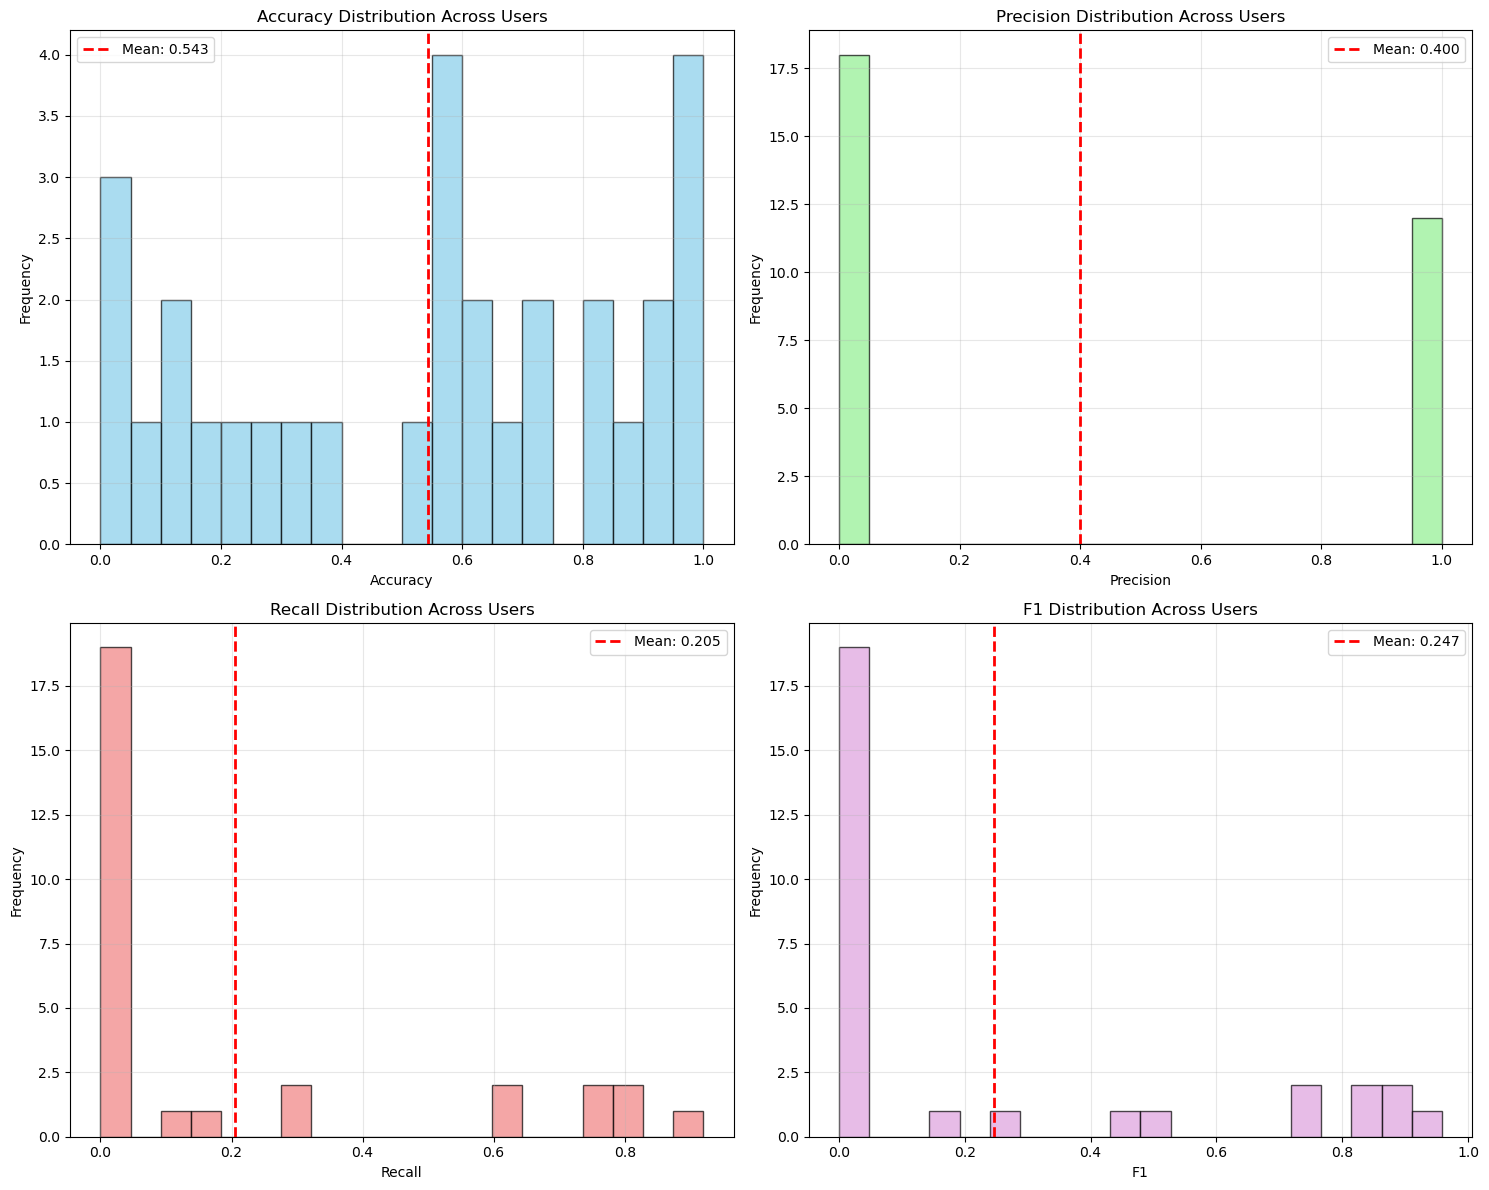

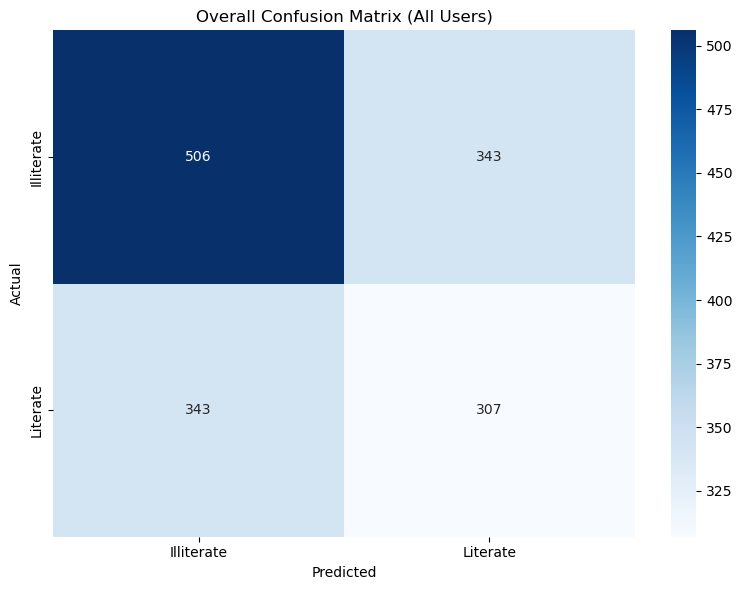

In [9]:
# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: Metrics distribution (histograms)
metrics = ['accuracy', 'precision', 'recall', 'f1']
colors = ['skyblue', 'lightgreen', 'lightcoral', 'plum']

for idx, (metric, color) in enumerate(zip(metrics, colors)):
    ax = axes[idx // 2, idx % 2]
    ax.hist(results_df[metric], bins=20, color=color, edgecolor='black', alpha=0.7)
    mean_val = results_df[metric].mean()
    ax.axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_val:.3f}')
    ax.set_xlabel(metric.capitalize())
    ax.set_ylabel('Frequency')
    ax.set_title(f'{metric.capitalize()} Distribution Across Users')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Plot 2: Confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Illiterate', 'Literate'],
            yticklabels=['Illiterate', 'Literate'])
plt.title('Overall Confusion Matrix (All Users)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

## Box Plot of Metrics

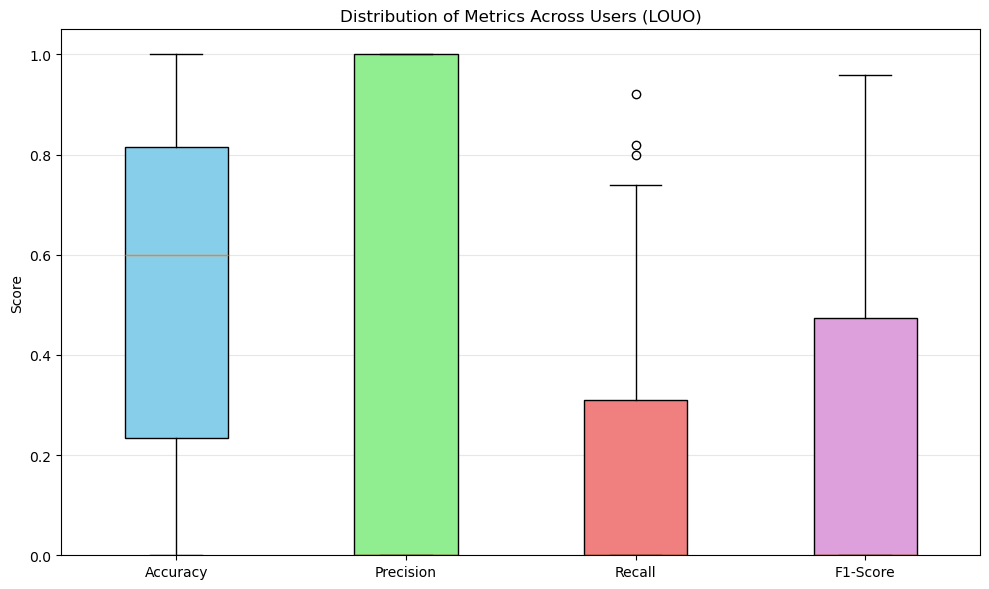

In [10]:
# Box plot of metrics across users
plt.figure(figsize=(10, 6))
metrics_data = [results_df['accuracy'], results_df['precision'], 
                results_df['recall'], results_df['f1']]
bp = plt.boxplot(metrics_data, labels=['Accuracy', 'Precision', 'Recall', 'F1-Score'],
                 patch_artist=True)

# Color the boxes
colors = ['skyblue', 'lightgreen', 'lightcoral', 'plum']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

plt.title('Distribution of Metrics Across Users (LOUO)')
plt.ylabel('Score')
plt.ylim(0, 1.05)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

## User Performance Heatmap

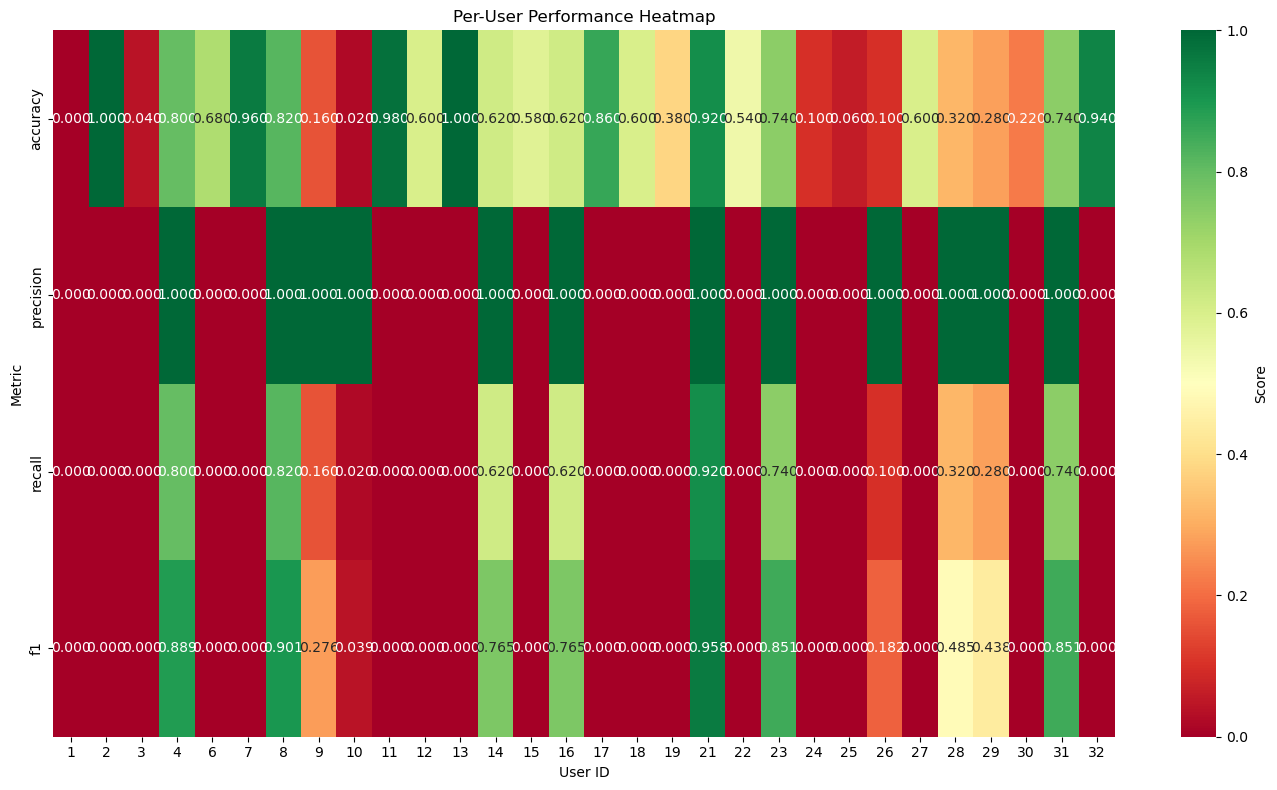

In [11]:
# Create heatmap of user performance
plt.figure(figsize=(14, 8))
heatmap_data = results_df.set_index('user_id')[['accuracy', 'precision', 'recall', 'f1']]
sns.heatmap(heatmap_data.T, annot=True, fmt='.3f', cmap='RdYlGn', 
            cbar_kws={'label': 'Score'}, vmin=0, vmax=1)
plt.title('Per-User Performance Heatmap')
plt.xlabel('User ID')
plt.ylabel('Metric')
plt.tight_layout()
plt.show()

## Statistical Summary

In [12]:
# Detailed statistical summary
print("\nDetailed Statistical Summary:")
print("="*60)
summary_stats = results_df[['accuracy', 'precision', 'recall', 'f1']].describe()
print(summary_stats)

# Best and worst performing users
print("\n" + "="*60)
print("Top 5 Users by Accuracy:")
print(results_df.nlargest(5, 'accuracy')[['user_id', 'accuracy', 'f1', 'n_samples']].to_string(index=False))

print("\nBottom 5 Users by Accuracy:")
print(results_df.nsmallest(5, 'accuracy')[['user_id', 'accuracy', 'f1', 'n_samples']].to_string(index=False))


Detailed Statistical Summary:
        accuracy  precision     recall         f1
count  30.000000  30.000000  30.000000  30.000000
mean    0.542653   0.400000   0.204667   0.246653
std     0.336730   0.498273   0.320718   0.364421
min     0.000000   0.000000   0.000000   0.000000
25%     0.235000   0.000000   0.000000   0.000000
50%     0.600000   0.000000   0.000000   0.000000
75%     0.815000   1.000000   0.310000   0.473011
max     1.000000   1.000000   0.920000   0.958333

Top 5 Users by Accuracy:
 user_id  accuracy  f1  n_samples
       2  1.000000 0.0         50
      13  1.000000 0.0         50
      11  0.979592 0.0         49
       7  0.960000 0.0         50
      32  0.940000 0.0         50

Bottom 5 Users by Accuracy:
 user_id  accuracy       f1  n_samples
       1      0.00 0.000000         50
      10      0.02 0.039216         50
       3      0.04 0.000000         50
      25      0.06 0.000000         50
      24      0.10 0.000000         50


## Data Statistics and Insights

In [13]:
# Analyze sequence lengths and feature statistics
sequence_lengths = [len(seq) for seq in dataset.sequences]
text_lengths = [len(text.split()) for text in dataset.text_sequences]

print("Dataset Statistics:")
print(f"Number of samples: {len(dataset)}")
print(f"Number of features: {len(FEATURE_COLUMNS)}")
print(f"Feature columns: {FEATURE_COLUMNS}")
print(f"Number of unique users: {len(unique_users)}")

print(f"\nSequence Length Statistics:")
print(f"Mean length: {np.mean(sequence_lengths):.1f}")
print(f"Median length: {np.median(sequence_lengths):.1f}")
print(f"Min length: {np.min(sequence_lengths)}")
print(f"Max length: {np.max(sequence_lengths)}")
print(f"Std deviation: {np.std(sequence_lengths):.1f}")

print(f"\nText Sequence Statistics:")
print(f"Mean text length (tokens): {np.mean(text_lengths):.1f}")
print(f"Max text length (tokens): {np.max(text_lengths)}")
print(f"Sequences exceeding BERT max length ({MAX_LENGTH}): {sum(1 for length in text_lengths if length > MAX_LENGTH)}")

# Samples per user
print(f"\nSamples per User:")
user_sample_counts = results_df[['user_id', 'n_samples']].sort_values('user_id')
print(f"Mean: {user_sample_counts['n_samples'].mean():.1f}")
print(f"Min: {user_sample_counts['n_samples'].min()}")
print(f"Max: {user_sample_counts['n_samples'].max()}")

Dataset Statistics:
Number of samples: 1499
Number of features: 6
Feature columns: ['FPOGX', 'FPOGY', 'LPS', 'RPS', 'LPMM', 'RPMM']
Number of unique users: 30

Sequence Length Statistics:
Mean length: 55.4
Median length: 43.0
Min length: 5
Max length: 449
Std deviation: 43.0

Text Sequence Statistics:
Mean text length (tokens): 332.3
Max text length (tokens): 2694
Sequences exceeding BERT max length (512): 242

Samples per User:
Mean: 50.0
Min: 49
Max: 50


## Sequence Length Distributions

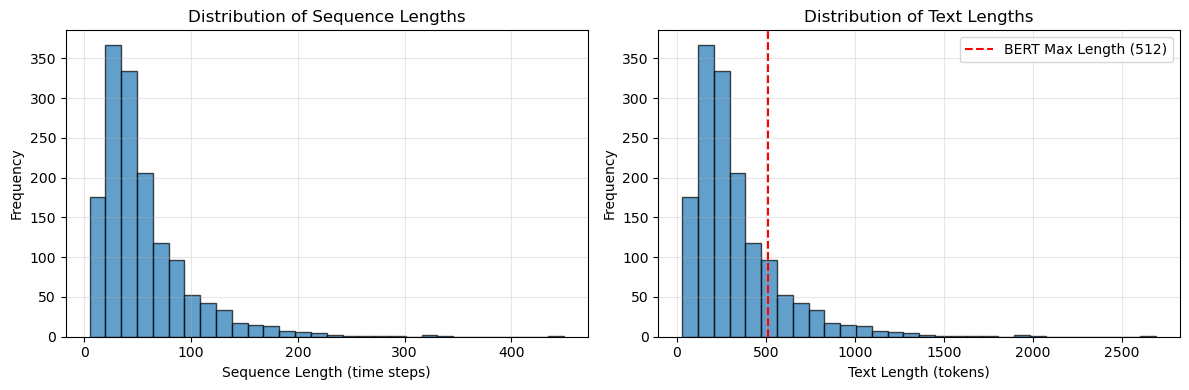

In [14]:
# Plot sequence length distribution
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(sequence_lengths, bins=30, alpha=0.7, edgecolor='black')
plt.xlabel('Sequence Length (time steps)')
plt.ylabel('Frequency')
plt.title('Distribution of Sequence Lengths')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.hist(text_lengths, bins=30, alpha=0.7, edgecolor='black')
plt.axvline(x=MAX_LENGTH, color='red', linestyle='--', label=f'BERT Max Length ({MAX_LENGTH})')
plt.xlabel('Text Length (tokens)')
plt.ylabel('Frequency')
plt.title('Distribution of Text Lengths')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Save Detailed Predictions

In [15]:
# Save detailed predictions
predictions_df = pd.DataFrame({
    'true_label': all_true_labels,
    'predicted_label': all_predictions,
    'correct': np.array(all_true_labels) == np.array(all_predictions)
})
predictions_df.to_csv('bert_6col_louo_predictions.csv', index=False)
print("Predictions saved to 'bert_6col_louo_predictions.csv'")

print("\nModel training and evaluation completed successfully!")

Predictions saved to 'bert_6col_louo_predictions.csv'

Model training and evaluation completed successfully!
